# Pylops / Pyproximal - comparison of solvers

### Author: M.Ravasi

In this notebook we will use the proximal gradient algorithm to solve a problem of signal reconstruction and compare its results with ISTA/FISTA or PyLops.

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import warnings
#warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

from copy import deepcopy
from scipy.sparse import csr_matrix, vstack
from scipy.linalg import lstsq, solve
from scipy.sparse.linalg import LinearOperator, cg, lsqr
from scipy import misc
from scipy.signal import triang

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.optimization.leastsquares  import *
from pylops.optimization.sparsity      import *

from pyproximal.proximal import *
from pyproximal import ProxOperator
from pyproximal.optimization.primal import *
from pyproximal.optimization.primaldual import *
from pyproximal.optimization.bregman import *
from pyproximal.utils import moreau

## 1D Interpolation

Consider the problem of reconstructing a regularly sampled signal of size $M$ from $N$ randomly selected samples:


$$\mathbf{y} = \mathbf{R} \mathbf{x}$$

where

$$\mathbf{y}= [y_1, y_2,...,y_N]^T, \qquad \mathbf{x}= [x_1, x_2,...,x_M]^T, \qquad $$

with $M>>N$ and R selects M elements from x at random locations

Create signal in frequency domain

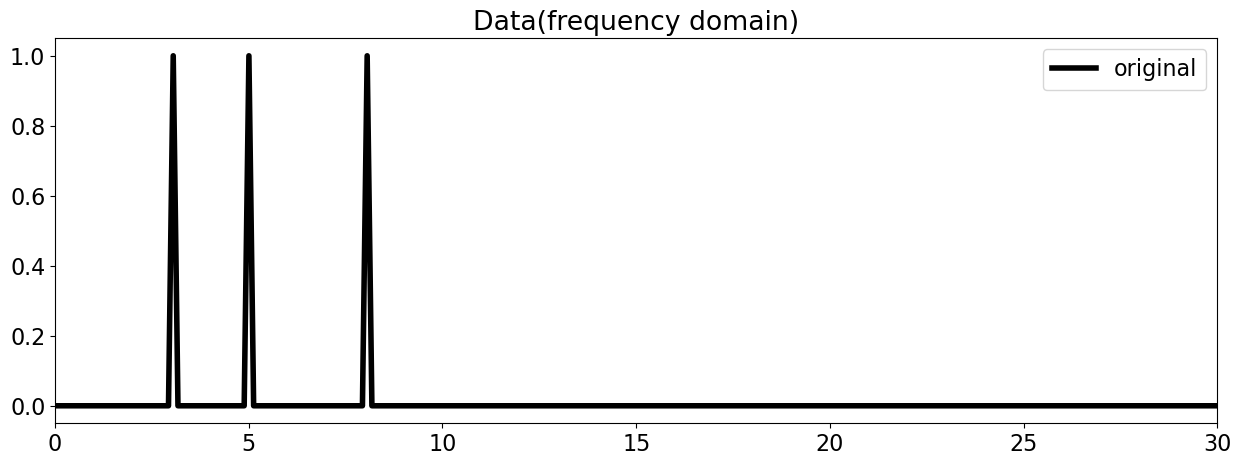

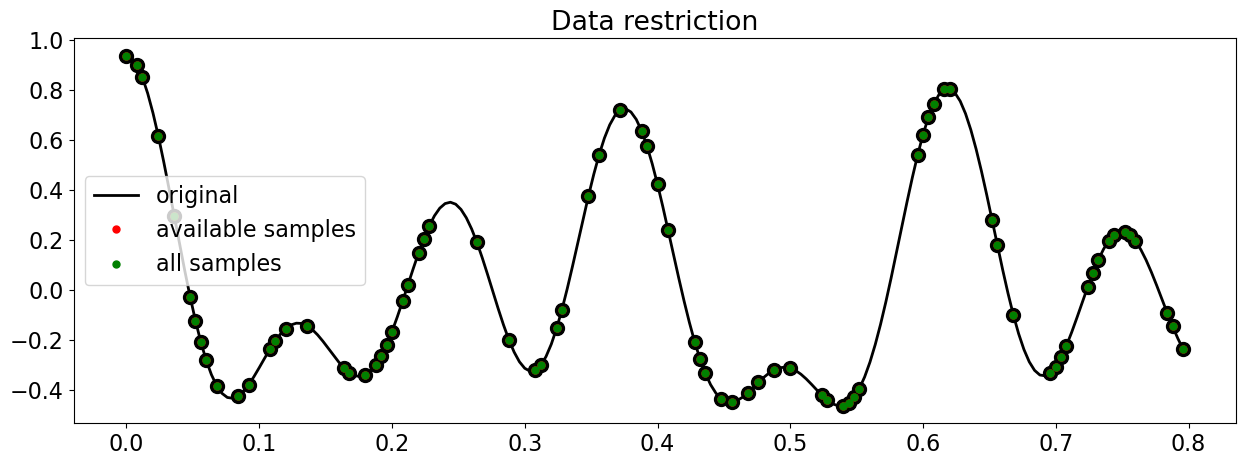

In [2]:
# Signal creation
N=200
dt=0.004
nfft=2**11
t = np.arange(N)*dt
f = np.fft.rfftfreq(nfft, dt)
ifreqs = [ 41, 25, 66]
freqs = f[ifreqs]

X = np.zeros(nfft//2+1, dtype='complex128')
X[ifreqs] = 1
FFTop = 10*FFT(N, nfft=nfft, real=True)
x = FFTop.H*X

fig = plt.figure(figsize=(15,5))
plt.plot(f, np.abs(X), 'k', lw=4, label='original')
plt.xlim(0,30)
plt.legend()
plt.title('Data(frequency domain)');

# subsampling locations
perc_subsampling=0.4
Nsub=int(np.round(N*perc_subsampling))

iava = np.sort(np.random.permutation(np.arange(N))[:Nsub])

# Create restriction operator
Rop = Restriction(N, iava, dtype='float64')
dottest(Rop,Nsub,N)

y     = Rop*x
ymask = Rop.mask(x)

# Visualize data
fig = plt.figure(figsize=(15,5))
plt.plot(t,       x,       'k' , lw=2,   label='original')
plt.plot(t[iava], x[iava], '.k', ms=20)
plt.plot(t[iava], y,       '.r', ms=10, label='available samples')
plt.plot(t,       ymask,   '.g', ms=10, label='all samples')
plt.legend()
plt.title('Data restriction');

### Sparsity promoting inversion - Synthesis problem

ISTA

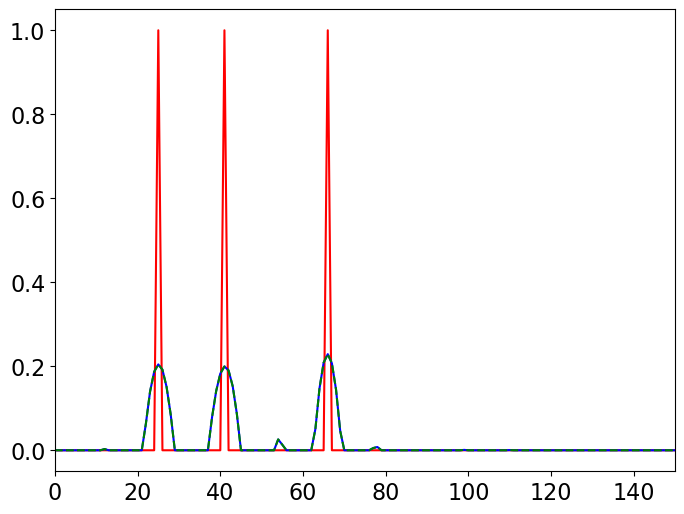

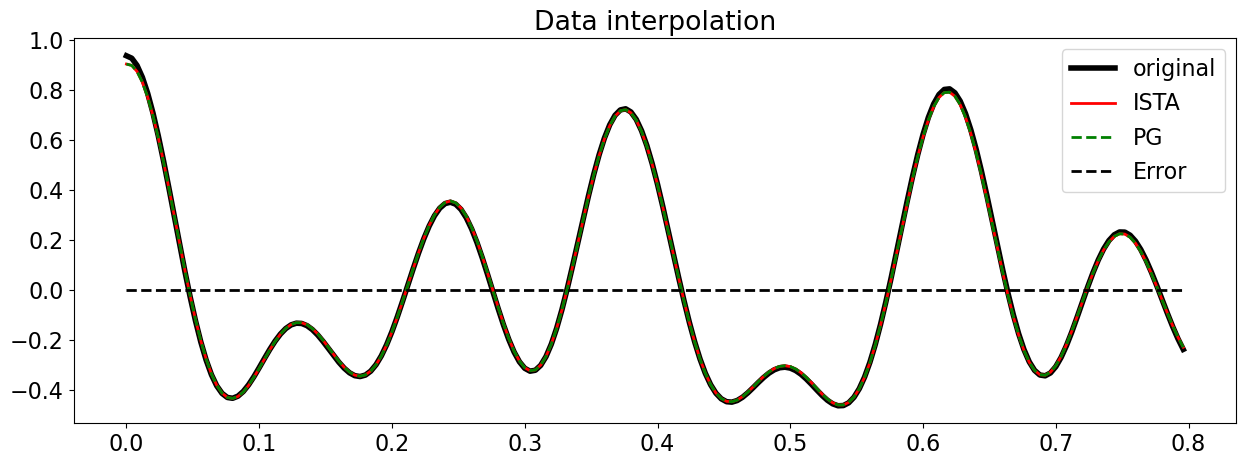

In [3]:
Op = Rop*FFTop.H
L = np.abs((Op.H * Op).eigs(1)[0])
eps = 0.1
niter = 1000
tau= 0.95/L

Xista, niter, cost = ista(Op, y, niter=niter, alpha=tau, eps=eps, 
                          tol=1e-8, monitorres=False, show=False)
xista = FFTop.H*Xista

l1 = L1()
l2 = L2(Op=Op, b=y)
epsg = eps * 0.5 # to compensate for 0.5 in ISTA: thresh = eps * alpha * 0.5
Xpg = ProximalGradient(l2, l1, tau=tau, x0=np.zeros(FFTop.shape[0], dtype=np.complex128), 
                       epsg=epsg, niter=niter, show=False)
xpg = FFTop.H*Xpg


plt.figure()
plt.plot(np.abs(X),'r')
plt.plot(np.abs(Xista), 'b')
plt.plot(np.abs(Xpg), '--g')
plt.xlim(0,150)

fig = plt.figure(figsize=(15,5))
plt.plot(t, x,              'k'   , lw=4,   label='original')
plt.plot(t, xista,  'r' , lw=2,   label='ISTA')
plt.plot(t, xpg,  '--g' , lw=2,   label='PG')
plt.plot(t, xista-xpg,  '--k' , lw=2,   label='Error')
plt.legend()
plt.title('Data interpolation');

Accelerated ISTA and FISTA

/Users/ravasim/Desktop/KAUST/OpenSource/pyproximal/pyproximal/optimization/primal.py:283: FutureWarning: AcceleratedProximalGradient has been integrated directly into ProximalGradient from v0.5.0. It is recommended to start using ProximalGradient by selecting the appropriate acceleration parameter as this behaviour will become default in version v1.0.0 and AcceleratedProximalGradient will be removed.
  warnings.warn('AcceleratedProximalGradient has been integrated directly into ProximalGradient '


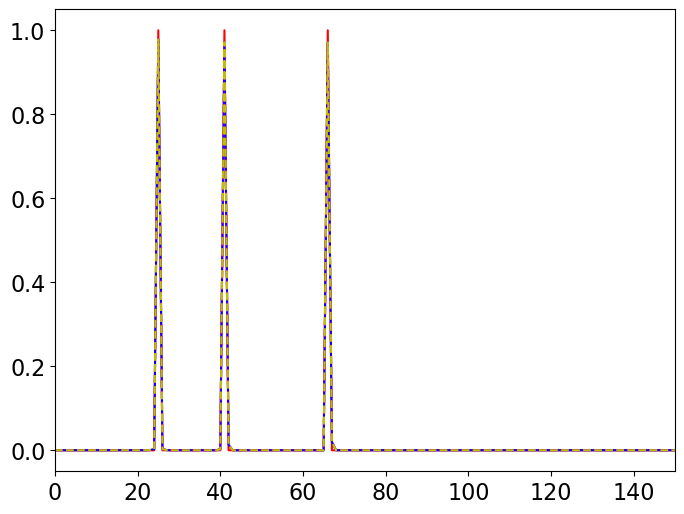

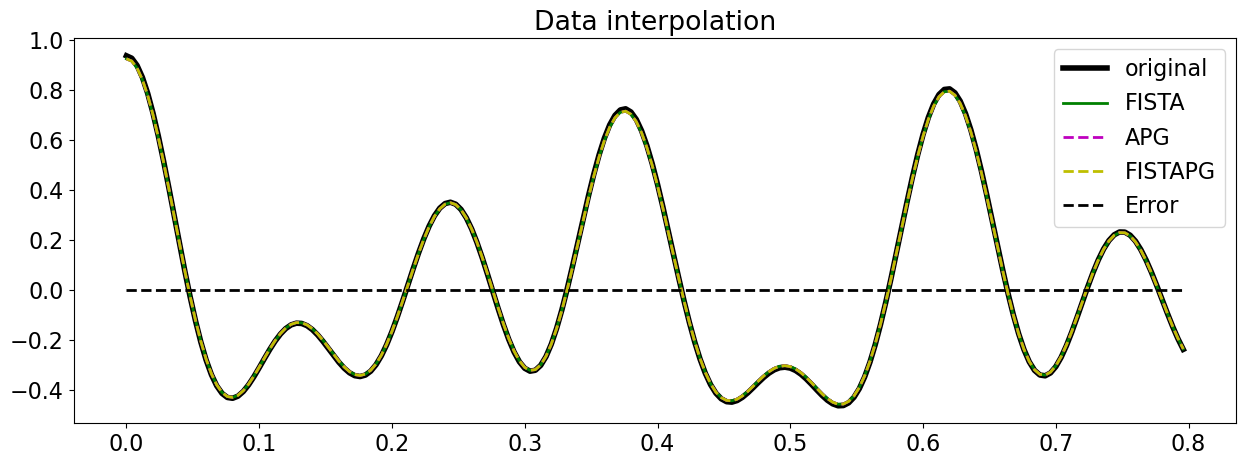

In [4]:
Xfista, niter1, cost1 = fista(Op, y, niter=niter, alpha=tau, eps=eps, 
                              tol=1e-8, show=False)
xfista = FFTop.H*Xfista

# vandenberghe_acc
Xapg = AcceleratedProximalGradient(l2, l1, tau=tau, x0=np.zeros(FFTop.shape[0], dtype=np.complex128), 
                                   epsg=epsg, niter=niter, acceleration='vandenberghe', show=False)
xapg = FFTop.H*Xapg

# fista
Xfistapg = AcceleratedProximalGradient(l2, l1, tau=tau, x0=np.zeros(FFTop.shape[0], dtype=np.complex128), 
                                       epsg=epsg, niter=niter, acceleration='fista', show=False)
xfistapg = FFTop.H*Xfistapg

plt.figure()
plt.plot(np.abs(X),'r')
plt.plot(np.abs(Xfista), 'b')
plt.plot(np.abs(Xapg), '--m')
plt.plot(np.abs(Xfistapg), '--y')
plt.xlim(0,150)

fig = plt.figure(figsize=(15,5))
plt.plot(t, x,              'k'   , lw=4,   label='original')
plt.plot(t, xfista,  'g' , lw=2,   label='FISTA')
plt.plot(t, xapg,  '--m' , lw=2,   label='APG')
plt.plot(t, xfistapg,  '--y' , lw=2,   label='FISTAPG')
plt.plot(t, xfista-xfistapg,  '--k' , lw=2,   label='Error')
plt.legend()
plt.title('Data interpolation');

### Sparsity promoting inversion - Analysis problem

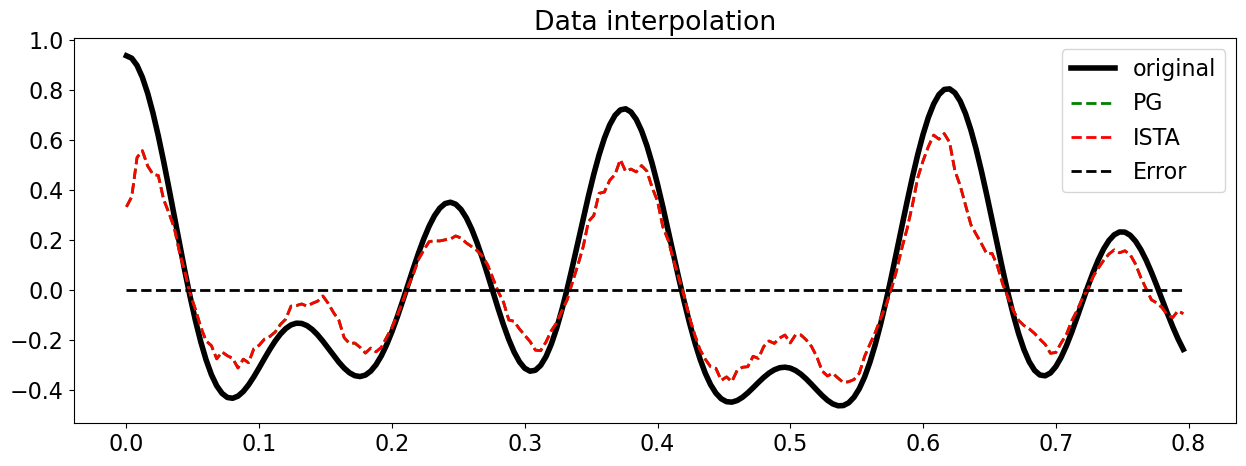

In [5]:
Rop.dtype = np.complex128
FFTop1 = FFT(N, nfft=nfft, real=True)
l1 = Orthogonal(L1(), FFTop1)
l2 = L2(Op=Rop, b=y)

L = np.abs((Op.H * Op).eigs(1)[0])
tau= 0.95/L
epsg = eps * 0.5
niter = 1000

xista, niter1, cost1 = ista(Rop, y, niter=niter, alpha=tau, eps=eps,  
                            SOp=FFTop1.H, tol=1e-8, show=False)

xpg = ProximalGradient(l2, l1, tau=tau, x0=np.zeros_like(x, dtype=np.complex128), 
                       epsg=epsg, niter=niter, show=False)


fig = plt.figure(figsize=(15,5))
plt.plot(t,       x,              'k'   , lw=4,   label='original')
plt.plot(t,       xpg,  '--g' , lw=2,   label='PG')
plt.plot(t,       xista,  '--r' , lw=2,   label='ISTA')
plt.plot(t, xista-xpg,  '--k' , lw=2,   label='Error')
plt.legend()
plt.title('Data interpolation');

## Deconvolution multiple RHS

In [6]:
Op = Rop*FFTop.H
L = np.abs((Op.H * Op).eigs(1)[0])
eps = 0.1
niter = 1000
tau= 0.95/L

Xista, niter, cost = ista(Op, y, niter=niter, alpha=tau, eps=eps, 
                          tol=1e-8, monitorres=False, show=False)
xista = FFTop.H*Xista

l1 = L1()
l2 = L2(Op=Op, b=y)
epsg = eps * 0.5 # to compensate for 0.5 in ISTA: thresh = eps * alpha * 0.5
Xpg = ProximalGradient(l2, l1, tau=tau, x0=np.zeros(FFTop.shape[0], dtype=np.complex128), 
                       epsg=epsg, niter=niter, show=False)
xpg = FFTop.H*Xpg

Accelerated Proximal Gradient
---------------------------------------------------------
Proximal operator (f): <class 'pyproximal.proximal.L2.L2'>
Proximal operator (g): <class 'pyproximal.proximal.L1.L1'>
tau = 0.03650566091281743	beta=5.000000e-01
epsg = 0.25	niter = 400	niterback = 100

   Itn       x[0]          f           g       J=f+eps*g
     1  -0.00000e+00   1.735e+00   9.260e+00   4.050e+00
     2  -0.00000e+00   9.660e-01   9.974e+00   3.459e+00
     3   0.00000e+00   7.528e-01   1.005e+01   3.266e+00
     4   0.00000e+00   6.555e-01   1.005e+01   3.169e+00
     5   0.00000e+00   6.004e-01   1.000e+01   3.101e+00
     6   0.00000e+00   5.648e-01   9.910e+00   3.042e+00
     7   0.00000e+00   5.298e-01   9.862e+00   2.995e+00
     8   0.00000e+00   5.010e-01   9.821e+00   2.956e+00
     9   0.00000e+00   4.761e-01   9.794e+00   2.925e+00
    10   0.00000e+00   4.577e-01   9.752e+00   2.896e+00
    41  -0.00000e+00   2.303e-01   9.160e+00   2.520e+00
    81  -0.00000e+00   1.

/Users/ravasim/Desktop/KAUST/OpenSource/pyproximal/pyproximal/optimization/primal.py:283: FutureWarning: AcceleratedProximalGradient has been integrated directly into ProximalGradient from v0.5.0. It is recommended to start using ProximalGradient by selecting the appropriate acceleration parameter as this behaviour will become default in version v1.0.0 and AcceleratedProximalGradient will be removed.
  warnings.warn('AcceleratedProximalGradient has been integrated directly into ProximalGradient '


   161  -0.00000e+00   1.173e-01   8.561e+00   2.258e+00
   201  -0.00000e+00   1.173e-01   8.561e+00   2.258e+00
   241  -0.00000e+00   1.175e-01   8.560e+00   2.258e+00
   281  -0.00000e+00   1.175e-01   8.560e+00   2.258e+00
   321  -0.00000e+00   1.175e-01   8.560e+00   2.258e+00
   361  -0.00000e+00   1.175e-01   8.560e+00   2.258e+00
   392  -0.00000e+00   1.175e-01   8.560e+00   2.258e+00
   393  -0.00000e+00   1.175e-01   8.560e+00   2.258e+00
   394  -0.00000e+00   1.175e-01   8.560e+00   2.258e+00
   395  -0.00000e+00   1.175e-01   8.560e+00   2.258e+00
   396  -0.00000e+00   1.175e-01   8.560e+00   2.258e+00
   397  -0.00000e+00   1.175e-01   8.560e+00   2.258e+00
   398  -0.00000e+00   1.175e-01   8.560e+00   2.258e+00
   399  -0.00000e+00   1.175e-01   8.560e+00   2.258e+00
   400  -0.00000e+00   1.175e-01   8.560e+00   2.258e+00

Total time (s) = 0.29
---------------------------------------------------------



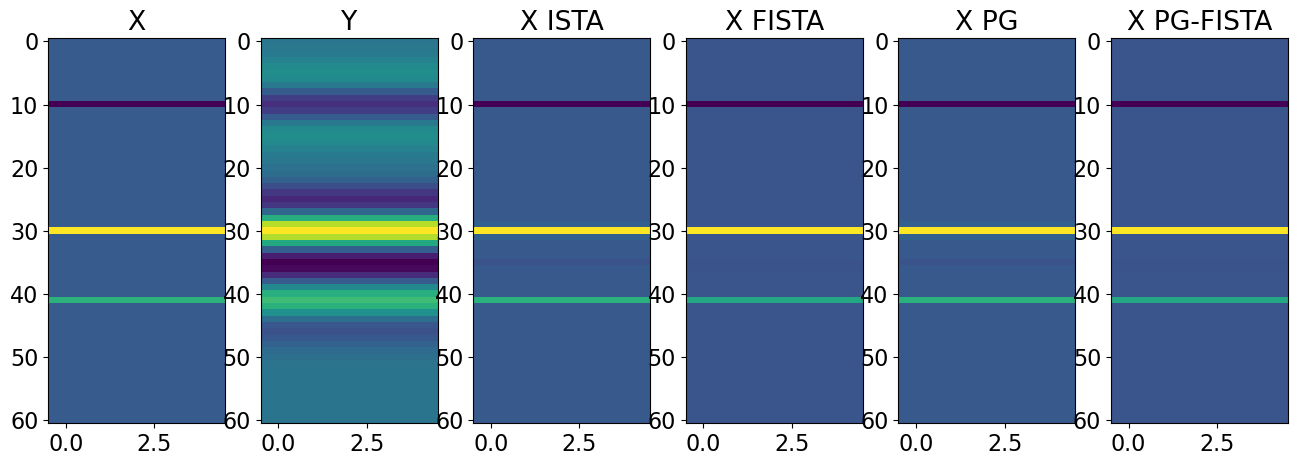

In [7]:
nt = 61
nx = 5
dt = 0.004
t = np.arange(nt)*dt
x = np.zeros(nt)
x[10] = -.4
x[int(nt/2)] = 1
x[nt-20] = 0.5
x = np.outer(x, np.ones(nx))

h, th, hcenter = ricker(t[:101], f0=20)

Cop = Convolve1D(nt, h=h, offset=hcenter, dtype=np.float32)
y = Cop*x

L = np.abs((Cop.H * Cop).eigs(1)[0])
tau= 0.95/L

xista, niteri, costi = ista(Cop, y, niter=400, alpha=tau, eps=5e-1,
                            tol=1e-8)
xfista, niteri, costi = fista(Cop, y, niter=400, alpha=tau, eps=5e-1,
                              tol=1e-8)

l1 = L1()
l2 = L2(Op=Cop, b=y)
epsg = 5e-1 * 0.5 # to compensate for 0.5 in ISTA: thresh = eps * alpha * 0.5
xpg = ProximalGradient(l2, l1, tau=tau, x0=np.zeros((nt, nx)), 
                       epsg=epsg, niter=400, show=True)
xpgfista = AcceleratedProximalGradient(l2, l1, tau=tau, x0=np.zeros((nt, nx)), 
                                       epsg=epsg, niter=400, acceleration='fista', show=True)


fig, axs = plt.subplots(1, 6, figsize=(16, 5))
axs[0].imshow(x)
axs[0].set_title('X')
axs[0].axis('tight')
axs[1].imshow(y)
axs[1].set_title('Y')
axs[1].axis('tight')
axs[2].imshow(xista)
axs[2].set_title('X ISTA')
axs[2].axis('tight')
axs[3].imshow(xfista)
axs[3].set_title('X FISTA')
axs[3].axis('tight')
axs[4].imshow(xpg)
axs[4].set_title('X PG')
axs[4].axis('tight')
axs[5].imshow(xpgfista)
axs[5].set_title('X PG-FISTA')
axs[5].axis('tight');

In [8]:
np.allclose(xista,xpg), np.allclose(xfista,xpgfista)

(True, True)

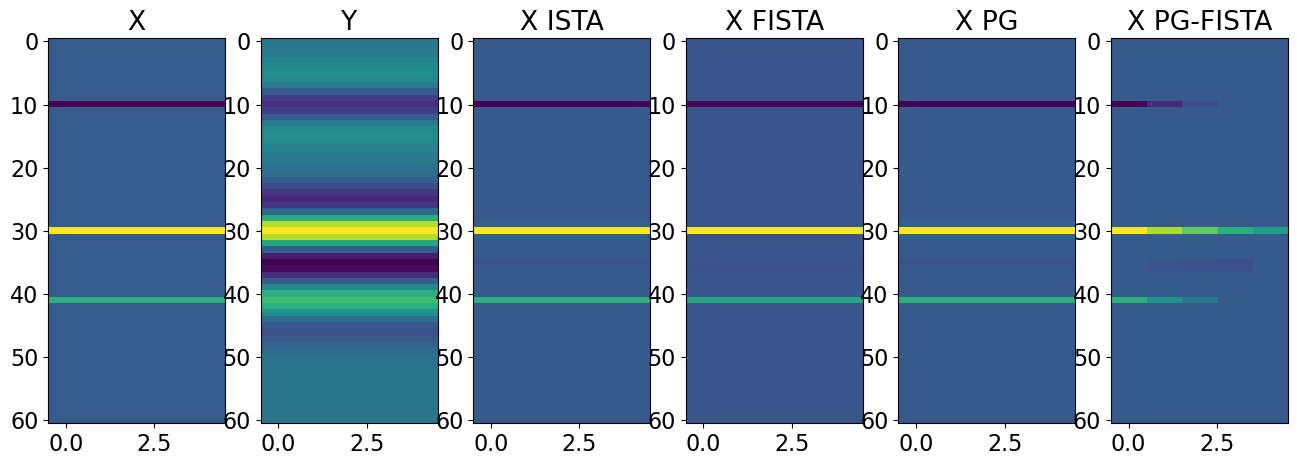

In [9]:
l1 = L1()
l2 = L2(Op=Cop, b=y)
epsg = np.linspace(0.1, 10, 5) * 5e-1 * 0.5 # to compensate for 0.5 in ISTA: thresh = eps * alpha * 0.5

xpgfista = AcceleratedProximalGradient(l2, l1, tau=tau, x0=np.zeros((nt, nx)), 
                                       epsg=epsg, niter=400, acceleration='fista', show=False)


fig, axs = plt.subplots(1, 6, figsize=(16, 5))
axs[0].imshow(x)
axs[0].set_title('X')
axs[0].axis('tight')
axs[1].imshow(y)
axs[1].set_title('Y')
axs[1].axis('tight')
axs[2].imshow(xista)
axs[2].set_title('X ISTA')
axs[2].axis('tight')
axs[3].imshow(xfista)
axs[3].set_title('X FISTA')
axs[3].axis('tight')
axs[4].imshow(xpg)
axs[4].set_title('X PG')
axs[4].axis('tight')
axs[5].imshow(xpgfista)
axs[5].set_title('X PG-FISTA')
axs[5].axis('tight');